In [1]:
import torch
from numpy import loadtxt,sqrt,ceil,floor
from matplotlib import pyplot as plt
from basis import KL,logprob_gamma
import nf_class
import pandas as pd


In [2]:

def prob_nf(xb,filename,N,met='sum'):
    if met == 'sum':
        model = nf_class.Deconvolver(x,a_distribution)
    if met == 'prod':
        model = nf_class.ProdDeconvolver(x,a_distribution)
    model.load_state_dict(torch.load('models/'+met+'_nf_'+filename.split('.')[0]+'datapoints_{}.pt'.format(N)))
    p_nf = model.get_pdf(xb)[1]
    return p_nf.to(xb.device)

def prob_bayes(xb,filename,N,met='sum'):
    if met == 'sum':
        shape,scale,lps =  torch.tensor(pd.read_csv('models/sum_bayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:].T)
    if met == 'prod':
        shape,scale,lps =  torch.tensor(pd.read_csv('models/prod_bayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:].T)

    i = torch.argmax(lps)
    p_map = torch.exp(logprob_gamma(xb,shape[i],scale[i]))

    logp = torch.logsumexp(torch.vstack([logprob_gamma(xb,sh,sc) for (sh,sc) in zip(shape,scale)]),axis=0)-torch.log(torch.tensor(len(lps)))#.to(device)
    p = torch.exp(logp)

    return p_map,p

logprob_gaussian = lambda x,mu,sig: -(((x-mu)/sig)**2)/2 - torch.log(sig) - 0.9189385175704956

def prob_npbayes(xb,filename,N,Ncomp=20,burn=5000,met='sum'):
    logprob_mixgaussian = lambda x,mus,sigs,rhos:torch.logsumexp(logprob_gaussian(x,mus.reshape(-1,1),sigs.reshape(-1,1))+torch.log(rhos.reshape(-1,1)),axis=0)
    
    if met == 'sum':
        logprob = logprob_mixgaussian
        g = pd.read_csv('models/sum_NPbayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:]
    elif met== 'prod':
        logprob_mixlognormal = lambda x,mus,sigs,rhos: logprob_mixgaussian(torch.log(x),mus,sigs,rhos)-torch.log(x)
        logprob = logprob_mixlognormal
        g = pd.read_csv('models/prod_NPbayes_'+filename.split('.')[0]+'datapoints_{}.csv'.format(N)).to_numpy()[:,1:]
        
    thetas,lps = torch.tensor(g[burn:,:-1]),torch.tensor(g[burn:,-1])

    i = torch.argmax(lps)
    th_map = thetas[i]
    p_map = torch.exp(logprob(xb,th_map[:Ncomp],th_map[Ncomp:2*Ncomp],th_map[2*Ncomp:]))

    logp = torch.logsumexp(torch.vstack([logprob(xb,th[:Ncomp],th[Ncomp:2*Ncomp],th[2*Ncomp:]) for th in thetas]),axis=0)-torch.log(torch.tensor(len(lps)))#.to(device)
    p = torch.exp(logp)

    return p_map,p
    
dfcolumns=['filename','method','N','KL_MAP','KL_reconstruct']    
def df_line(filename,met,N,xb,p_gt,p_map,p_rec=None):
    kl_map = KL(p_gt,p_map,xb).item()
    if p_rec is None:
        kl_rec = kl_map
    else:
        kl_rec = KL(p_gt,p_rec,xb).item()
    return pd.DataFrame ([[filename,met,N,kl_map,kl_rec]], columns=dfcolumns)

plot_cols = ['Data', 'Bayesian with known model', 'Bayesian with Gaussian mixture', 'NFdeconvolve']
def make_graph(ax,x,xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec):
    ax[0].hist(x,density=True)
    ax[0].set_ylabel('N={}'.format(x.size(0)))

    [axi.plot(xb,p_gt,color='k',label='Ground Truth') for axi in ax[1:]]

    ax[1].plot(xb,bayes_map,label='MAP')
    ax[1].plot(xb,bayes_rec,label='Reconstruction')

    ax[2].plot(xb,npbayes_map,label='MAP')
    ax[2].plot(xb,npbayes_rec,label='Reconstruction')

    ax[3].plot(xb,p_nf,color='r',label='NFdeconvolve')

    [axi.legend() for axi in ax[1:]]
    
    
    



/home/pessoa/Codes/Zeta/nf_class.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.center = torch.tensor(center).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.width = torch.tensor(width).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.center = torch.tensor(center).to(device)
/home/pessoa/Codes/Zeta/nf_class.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

TypeError: '<' not supported between instances of 'float' and 'method'

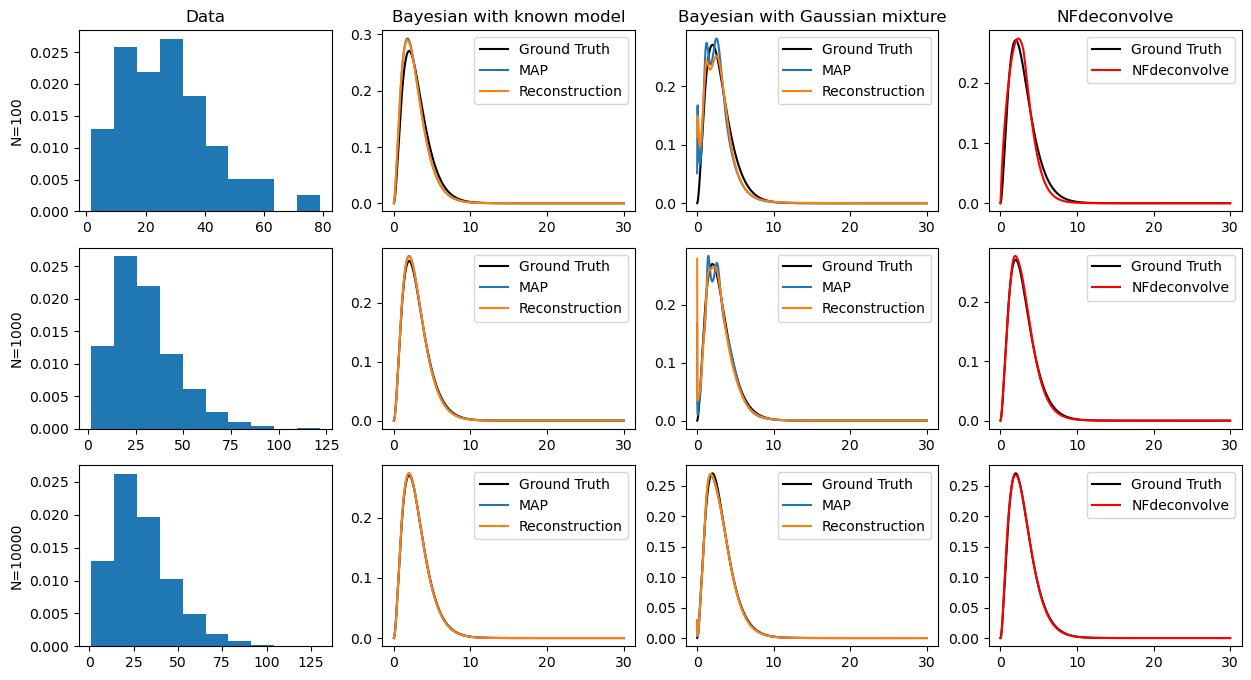

In [3]:
##MAIN sum examples

# mu_a,sig_a = 10,1
# df_sum = pd.DataFrame(columns=dfcolumns)

# for shape in range(3,10):
#     shape_gt,scale_gt = shape,1
#     filename = 'N_{}_{}_G_{}_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt)
#     a_distribution= torch.distributions.Normal(torch.tensor(mu_a).float(),torch.tensor(sig_a).float())

#     fig,ax = plt.subplots(3,4,figsize=(15,8))
#     for N,plot_row in zip([100,316,1000,3160,10000],[0,None,1,None,2]):
#         x = torch.tensor(loadtxt('datasets/'+filename)[:N]).float()
#         xb = torch.linspace((x.min().item()/(mu_a+3*sig_a)),
#                             ceil(x.max().item()/(mu_a-3*sig_a)),10000)
        
        
#         p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape_gt),torch.tensor(scale_gt)))
#         p_nf = prob_nf(xb,filename,N,met='sum')
#         bayes_map,bayes_rec = prob_bayes(xb,filename,N,met='sum')
#         npbayes_map,npbayes_rec = prob_npbayes(xb,filename,N,met='sum')
   
#         df_sum = pd.concat((df_sum,
#                                 df_line(filename,'NF',N,xb,p_gt,p_nf),
#                                 df_line(filename,'Bayes',N,xb,p_gt,bayes_map,bayes_rec),
#                                 df_line(filename,'NPBayes',N,xb,p_gt,npbayes_map,npbayes_rec)),ignore_index=True)
        
#         if isinstance(plot_row,int):
#             make_graph(ax[plot_row],x,xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec)
        
#     [axi.set_title(col) for (col,axi) in zip(plot_cols,ax[0])]
#     fig.savefig('graphs/sum_'+filename.split('.')[0]+'.png',dpi=500)

# df_sum.to_csv('report.csv',index=False)

##MAIN product examples

mu_a,sig_a = 10,1
df_prod = pd.DataFrame(columns=dfcolumns)

for shape in range(3,10):
    shape_gt,scale_gt = shape,1
    filename = 'N_{}_{}_G_{}_{}.csv'.format(mu_a,sig_a,shape_gt,scale_gt)
    a_distribution= torch.distributions.Normal(torch.tensor(mu_a).float(),torch.tensor(sig_a).float())

    fig,ax = plt.subplots(3,4,figsize=(15,8))
    for N,plot_row in zip([100,316,1000,3160,10000],[0,None,1,None,2]):
        x = torch.tensor(loadtxt('datasets/'+'prod_'+filename)).float()
        xb = torch.linspace((x.min().item()/(mu_a+3*sig_a)),
                            ceil(x.max().item()/(mu_a-3*sig_a)),10000)
        
        
        p_gt = torch.exp(logprob_gamma(xb,torch.tensor(shape_gt),torch.tensor(scale_gt)))

        p_nf = prob_nf(xb,'prod_'+filename,N,met='prod')
        bayes_map,bayes_rec = prob_bayes(xb,'prod_'+filename,N,met='prod')
        npbayes_map,npbayes_rec = prob_npbayes(xb,'prod_'+filename,N,met='prod')
   
        df_prod = pd.concat((df_prod,
                                df_line(filename,'NF',N,xb,p_gt,p_nf),
                                df_line(filename,'Bayes',N,xb,p_gt,bayes_map,bayes_rec),
                                df_line(filename,'NPBayes',N,xb,p_gt,npbayes_map,npbayes_rec)
                                ),ignore_index=True)
        
        if isinstance(plot_row,int):
            make_graph(ax[plot_row],x[:N],xb,p_gt,p_nf,bayes_map,bayes_rec,npbayes_map,npbayes_rec)
        
    [axi.set_title(col) for (col,axi) in zip(plot_cols,ax[0])]
    [axi.set_xlim(0,x.max().item) for axi in ax[:,0]]
    plt.tight_layout()
    plt.savefig('graphs/prod_'+filename.split('.')[0]+'.png',dpi=500)

df_prod.to_csv('report_prod.csv',index=False)

In [ ]:
filename.split('.')[0]

'N_10_1_G_9_1'